In [2]:
from src import *

## Description

We investigate the dynamic gradients connectivity for single acquisitions. (i.e we process at individual level) Looking at aligned gradient's centroid and concentration

GOAL: Visualize over time topology change of connectivity gradients and analysing region clusters' shifts and concentration

### Standard Sliding window Dynamic
In literature, for dynamic windows, it is usually recommended to have over 30 TR in one window. Now however empirically we do not have stability in the case and will therefore as well look into longer TR windows.

## Table of Contents
Individual Dynamics
- [Standard Sliding window Dynamic (Individual)](#individual)

Group Level Dynamics
- [Standard Sliding window Dynamic (Group)](#group)

Quick Test
- [Sliding window Size against explained variance (Investigate)](#windowsize)

<a class="anchor" id="individual"></a>
## Individual Dynamic Gradients

In [3]:
front_pad = int(WASH + ONSET) + 1

embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
nb_comp    = 10
rs         = 12593

mri_path = "./data/fmri400_compiled/"

#### We generate / save the dynamic gradients generated for all movies

In [3]:
# variable for dFC
ws   = 40
step = 1 # let's overlap pretty much all for now to see smoothness

for i in tqdm(range(len(os.listdir(mri_path)))):
    movie_name   = os.listdir(mri_path)[i]
    mri_df       = pd.read_csv(mri_path + movie_name)
    if "Rest" in movie_name:
        end = -1
    else:
        film_duration = FILM2DURATION[movie_name.split('_')[0]] # in seconds
        duration_film = int(film_duration/ TR) # in number of TRs
        end           = front_pad + duration_film

    subject_grad = {}
    acqui        = [k for k in mri_df.filename.unique() if '400' in k]
    for filename_movie in acqui:
        subject         = filename_movie.split('_')[2].split('-')[1]
        movie_series, _ = df_to_timeseries(mri_df, filename_movie)
        movie_series    = movie_series[front_pad : end]

        dFC_movie = sliding_window_FC(movie_series, ws, step=step)

        # Sliding window Dynamic Gradients
        gref_movie = None
        G_movie    = []
        variancesM = []
        for widx in range(0, len(dFC_movie)):

            galign = GradientMaps(n_components=nb_comp, kernel=aff_kernel, approach=embedding, alignment=align_meth
                                            , random_state=rs)
            galign.fit(dFC_movie[widx], reference=gref_movie)
            variancesM.append(galign.lambdas_)
            if widx == 0:
                G_movie.append(galign.gradients_)
                gref_movie = galign.gradients_
            else:
                # Aligning from previous Gradient
                G_movie.append(galign.aligned_)
                gref_movie = galign.aligned_

        G_movie    = np.asarray(G_movie)
        variancesM = np.asarray(variancesM)
        subject_grad[subject] = (G_movie, variancesM)

    save('./resources/dynamic_grad/individual_level/'+movie_name.split('_')[0]+'_{}_grad.pkl'.format(ws),subject_grad)

 87%|████████▋ | 13/15 [2:04:06<19:05, 572.77s/it] 


OSError: [Errno 28] No space left on device

#### Joint plot 1st and 2nd Gradient

In [14]:
grads = load('./resources/dynamic_grad/individual_level/TheSecretNumber_grad.pkl')
subj_grad,variances = grads['S30'] 

In [20]:
partial_region = load('./resources/region400yeo7.pkl')
coloring  = [partial_region[i] for i in range(400)]
pal       = sns.color_palette('colorblind', 8)

for j in tqdm(range(len(subj_grad))):
    tmp_df = {"G1":subj_grad[j][:,0] , "G2": subj_grad[j][:,1], "region": coloring}
    tmp_df = pd.DataFrame.from_dict(tmp_df)
    ax     = sns.jointplot(data=tmp_df, x="G1", y="G2", 
                hue="region", height=7, 
                xlim=(subj_grad[:,:,0].min()-10,subj_grad[:,:,0].max()+10), 
                ylim=(subj_grad[:,:,1].min()-10,subj_grad[:,:,1].max()+10), palette=pal)
    ax.fig.suptitle("Gradients's closenedness plot ({})".format(movie_name.split('_')[0]), fontsize=12)
    legend_properties = {'weight':'bold','size':5}
    ax.ax_joint.legend(prop=legend_properties,loc='upper right')
    ax.ax_joint.set_xlabel('G1',fontsize=10)
    ax.ax_joint.set_ylabel('G2',fontsize=10)
    ax.savefig("./media/gradient_plots/{}_{}.jpg".format(movie_name.split('_')[0],j))

    #this is the line to be added to avoid showing all the list of plots
    plt.close("all")

100%|██████████| 354/354 [02:00<00:00,  2.94it/s]


In [25]:
# path = "./media/gradient_plots/"

# # reorder saved images path
# movie_path  = loadimg_in_order([m for m in os.listdir(path)])
# movie_array = [cv2.imread(path+'/'+filename) for filename in movie_path]

# img2video(movie_array, 10, outpath_name='./media/{}_plots_ws{}.mp4'.format(movie_name.split('_')[0],ws))

#### Dynamic change on cortical surfaces plottings

In [26]:
from copy import deepcopy

# artificially modify values for display, artifact inducing
display_gs = deepcopy(subj_grad)
display_gs[:,0,0] = display_gs[:,:,0].max()
display_gs[:,1,0] = display_gs[:,:,0].min()
display_gs[:,0,1] = display_gs[:,:,1].max()
display_gs[:,1,1] = display_gs[:,:,1].min()

labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0

In [30]:
for j in tqdm(range(len(display_gs))):
    grad = [None] * 2
    for k in range(2):
        # map the gradient to the parcels
        grad[k] = map_to_labels(display_gs[j,:, k], labeling, mask=mask, fill=np.nan)

    plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 600), cmap='viridis_r',
                 color_bar=True, label_text=['Grad1-Sintel', 'Grad2-Sintel'], zoom=1.2, embed_nb=False, interactive=False,
                 transparent_bg=False, filename='./media/hemisphere_gradients/{}_{}.jpg'.format(movie_name.split('_')[0],j), screenshot=True)


  0%|          | 0/354 [00:00<?, ?it/s]/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(
100%|██████████| 354/354 [00:34<00:00, 10.17it/s]


In [31]:
# path = "./media/hemisphere_gradients/"
# # reorder saved images path
# movie_path  = loadimg_in_order([m for m in os.listdir(path) if movie_name.split('_')[0] in m])
# movie_array = [cv2.imread(path+'/'+filename)[:,:,::-1] for filename in movie_path]

# img2video(movie_array, 30, outpath_name='./media/{}_hemisphere_ws{}.mp4'.format(movie_name.split('_')[0],ws))

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


<a class="anchor" id="group"></a>
## Group Dynamic Gradients

#### We generate / save the dynamic gradients generated for all movies

In [35]:
# variable for dFC
ws   = 40
step = 1 # let's overlap pretty much all for now to see smoothness

for i in tqdm(range(len(os.listdir(mri_path)))):
    movie_name   = os.listdir(mri_path)[i]
    mri_df       = pd.read_csv(mri_path + movie_name)
    if "Rest" in movie_name:
        end = -1
    else:
        film_duration = FILM2DURATION[movie_name.split('_')[0]] # in seconds
        duration_film = int(film_duration/ TR) # in number of TRs
        end           = front_pad + duration_film

    group_series = []
    acqui        = [k for k in mri_df.filename.unique() if '400' in k]
    for filename_movie in acqui:
        subject         = filename_movie.split('_')[2].split('-')[1]
        movie_series, _ = df_to_timeseries(mri_df, filename_movie)
        movie_series    = movie_series[front_pad : end]
        group_series.append(movie_series)
    
    group_series = np.asarray(group_series)
    nbs,nbt,nbr  = group_series.shape
    dFC_movie    = np.zeros(((nbt - ws) // step + 1, nbr,nbr))

    for c, sidx in enumerate(range(0, nbt, step)):
        T = group_series[:,sidx:sidx+ws]
        if T.shape[1] != ws: 
            continue
        # we concatenate across subjects
        T = np.concatenate(T)
        dFC_movie[c] = FC(T)

    # Sliding window Dynamic Gradients
    gref_movie = None
    G_movie    = []
    variancesM = []
    for widx in range(0, len(dFC_movie)):
        galign = GradientMaps(n_components=nb_comp, kernel=aff_kernel, approach=embedding, alignment=align_meth
                                        , random_state=rs)
        galign.fit(dFC_movie[widx], reference=gref_movie)
        variancesM.append(galign.lambdas_)
        if widx == 0:
            G_movie.append(galign.gradients_)
            gref_movie = galign.gradients_
        else:
            # Aligning from previous Gradient
            G_movie.append(galign.aligned_)
            gref_movie = galign.aligned_

    G_movie    = np.asarray(G_movie)
    variancesM = np.asarray(variancesM)

    save('./resources/dynamic_grad/group_level/'+movie_name.split('_')[0]+'_{}_grad.pkl'.format(ws),[G_movie, variancesM])

100%|██████████| 15/15 [12:29<00:00, 49.97s/it]


#### Joint plot 1st and 2nd Gradient

In [9]:
movie_name = "Rest"
group_grad,variances = load('./resources/dynamic_grad/group_level/Rest_40_grad.pkl')

In [10]:
partial_region = load('./resources/region400yeo7.pkl')
coloring  = [partial_region[i] for i in range(400)]
pal       = sns.color_palette('colorblind', 8)

for j in tqdm(range(len(group_grad))):
    tmp_df = {"G1":group_grad[j][:,0] , "G2": group_grad[j][:,1], "region": coloring}
    tmp_df = pd.DataFrame.from_dict(tmp_df)
    ax     = sns.jointplot(data=tmp_df, x="G1", y="G2", 
                hue="region", height=5, 
                xlim=(group_grad[:,:,0].min()-10,group_grad[:,:,0].max()+10), 
                ylim=(group_grad[:,:,1].min()-10,group_grad[:,:,1].max()+10), palette=pal)
    ax.fig.suptitle("Gradients's closenedness plot ({})".format(movie_name))
    legend_properties = {'weight':'bold','size':5}
    ax.ax_joint.legend(prop=legend_properties,loc='upper right')
    ax.savefig("./media/gradient_plots/{}_{}.jpg".format(movie_name,j))

    #this is the line to be added to avoid showing all the list of plots
    plt.close("all")

  0%|          | 0/343 [00:00<?, ?it/s]/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/seaborn/axisgrid.py:1826: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)
/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/seaborn/axisgrid.py:1877: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/seaborn/axisgrid.py:1883: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)
  0%|          | 1/343 [00:19<1:52:31, 19.74s/it]/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/seaborn/axisgrid.py:1826: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  func(

In [11]:
path = "./media/gradient_plots/"

# reorder saved images path
movie_path  = loadimg_in_order([m for m in os.listdir(path)])
movie_array = [cv2.imread(path+'/'+filename) for filename in movie_path if movie_name in filename]

ws = 40
img2video(movie_array, 10, outpath_name='./media/{}_plots_ws{}.mp4'.format(movie_name.split('_')[0],ws))

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Plot on cortical surfaces would use the same code as above, just copy that.

<a class="anchor" id="windowsize"></a>
## Window size Dynamic Gradient Generation
We generate dynamic gradient over various windows and log the changes to then analyze in the `fmri_gradient_metrics.ipynb` notebook.

In [12]:
movie_name   = os.listdir(mri_path)[0]
mri_df       = pd.read_csv(mri_path + movie_name)
mri_df2      = pd.read_csv(mri_path + '/Rest_compiled.csv')

film_duration = FILM2DURATION[movie_name.split('_')[0]] # in seconds
duration_film = int(film_duration/ TR) # in number of TRs
end           = front_pad + duration_film

filename_movie  = mri_df[mri_df.parcel==400].iloc[0].filename
filename_rest   = mri_df2[mri_df2.parcel==400].iloc[0].filename

movie_series, _ = df_to_timeseries(mri_df, filename_movie)
movie_series    = movie_series[front_pad : end]
rest_series, _  = df_to_timeseries(mri_df2, filename_rest)

In [13]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
nb_comp    = 10
rs         = 12593
WS = np.arange(30, 250, 10)

We compute explained variances comparing Rest and Movie across window sizes

In [14]:
# Computing the dynamic gradients for both a rest sample from 1 subject and a movie sample from 1 subject
gref = None
variances = []
for ws in tqdm(WS):
    cur_vars = []
    dFC = sliding_window_FC(rest_series, ws, step=2)
    for widx in range(0, len(dFC)):
        galign = GradientMaps(n_components=nb_comp, kernel=aff_kernel, approach=embedding, 
                            alignment=align_meth, random_state=rs)
        galign.fit(dFC[widx], reference=gref)
        cur_vars.append(galign.lambdas_)
        if widx == 0:
            gref = galign.gradients_
    variances.append(cur_vars)

gref = None
variances2 = []
for ws in tqdm(WS):
    cur_vars = []
    dFC = sliding_window_FC(movie_series, ws, step=2)
    for widx in range(0, len(dFC)):
        galign = GradientMaps(n_components=nb_comp, kernel=aff_kernel, approach=embedding, 
                            alignment=align_meth, random_state=rs)
        galign.fit(dFC[widx], reference=gref)
        cur_vars.append(galign.lambdas_)
        if widx == 0:
            gref = galign.gradients_
    variances2.append(cur_vars)

100%|██████████| 22/22 [02:28<00:00,  6.74s/it]


In [15]:
stats_var = [np.array(variances[i]).mean(axis=0) for i in range(len(variances))]
stats_var = np.asarray(stats_var)

stats_var2 = [np.array(variances2[i]).mean(axis=0) for i in range(len(variances2))]
stats_var2 = np.asarray(stats_var2)

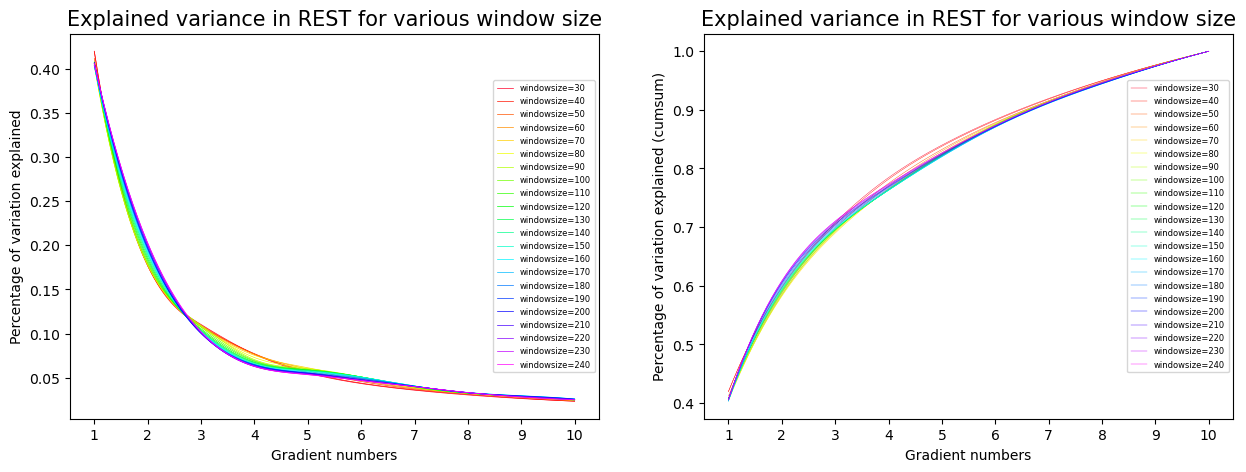

In [22]:
from scipy.interpolate import make_interp_spline

NUM_COLORS = len(stats_var)
cm = plt.get_cmap('gist_rainbow')
fig,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax[1].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for i in range(NUM_COLORS):
    y = stats_var[i]/stats_var[i].sum()
    x = np.arange(len(y))
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)
    ax[0].plot(X_+1,Y_, label='windowsize={}'.format(WS[i]), linewidth = .5)

    y  = np.cumsum(y)
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_, )
    ax[1].plot(X_+1,Y_, label='windowsize={}'.format(WS[i]), linewidth = .3)

for i in range(2):
    ax[i].legend(loc=5, prop={'size': 6})
    ax[i].set_title('Explained variance in REST for various window size', size=15)
    ax[i].set_xlabel('Gradient numbers', size=10)
    if i == 0:
        ax[i].set_ylabel('Percentage of variation explained', size=10)
    else:
        ax[i].set_ylabel('Percentage of variation explained (cumsum)', size=10)

    ax[i].set_xticks(np.arange(1,len(x)+1))

plt.show()

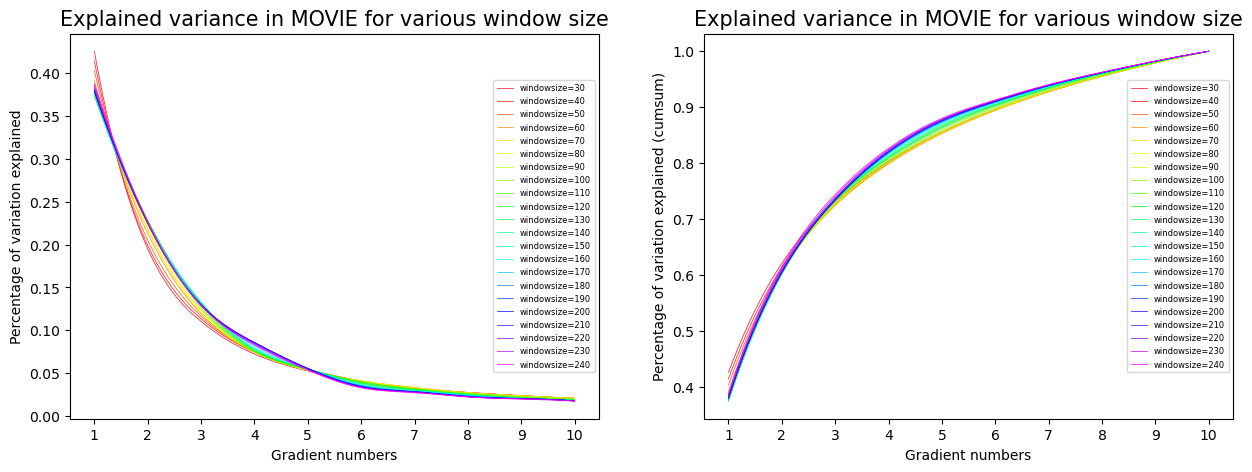

: 

In [23]:
from scipy.interpolate import make_interp_spline

NUM_COLORS = len(stats_var)
cm = plt.get_cmap('gist_rainbow')
fig,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax[1].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for i in range(NUM_COLORS):
    y = stats_var2[i]/stats_var2[i].sum()
    x = np.arange(len(y))
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)
    ax[0].plot(X_+1,Y_, label='windowsize={}'.format(WS[i]), linewidth = .5)

    y  = np.cumsum(y)
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_, )
    ax[1].plot(X_+1,Y_, label='windowsize={}'.format(WS[i]), linewidth = .5)

for i in range(2):
    ax[i].legend(loc=5, prop={'size': 6})
    ax[i].set_title('Explained variance in MOVIE for various window size', size=15)
    ax[i].set_xlabel('Gradient numbers', size=10)
    ax[i].set_xticks(np.arange(1,len(x)+1))
    if i == 0:
        ax[i].set_ylabel('Percentage of variation explained', size=10)
    else:
        ax[i].set_ylabel('Percentage of variation explained (cumsum)', size=10)
plt.show()